Dataset Shape: (1460, 81)
Data Types:
 Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object

Missing values after cleansing: 871


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


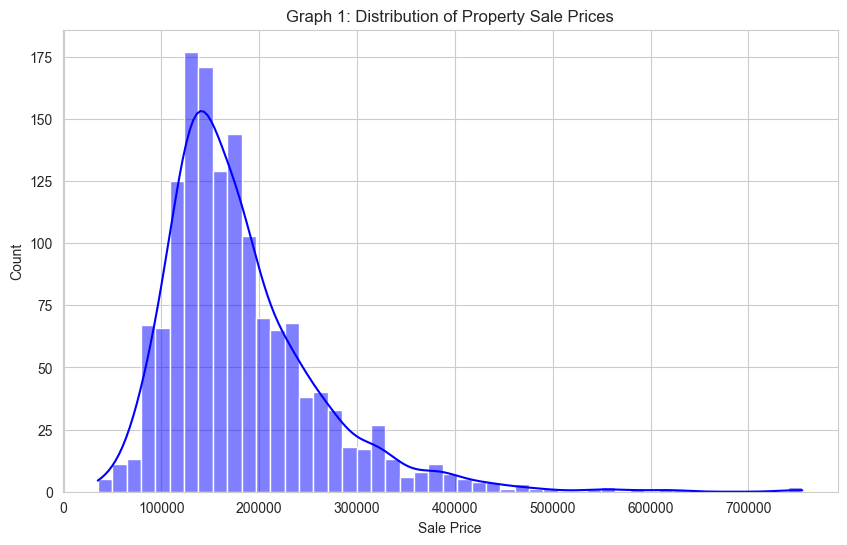

/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_47622/3229840152.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='viridis')


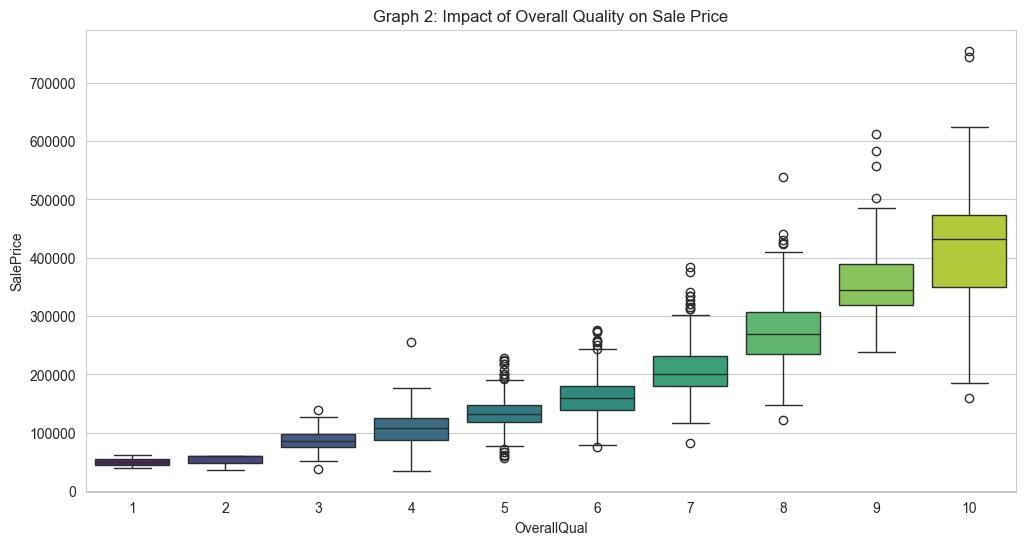

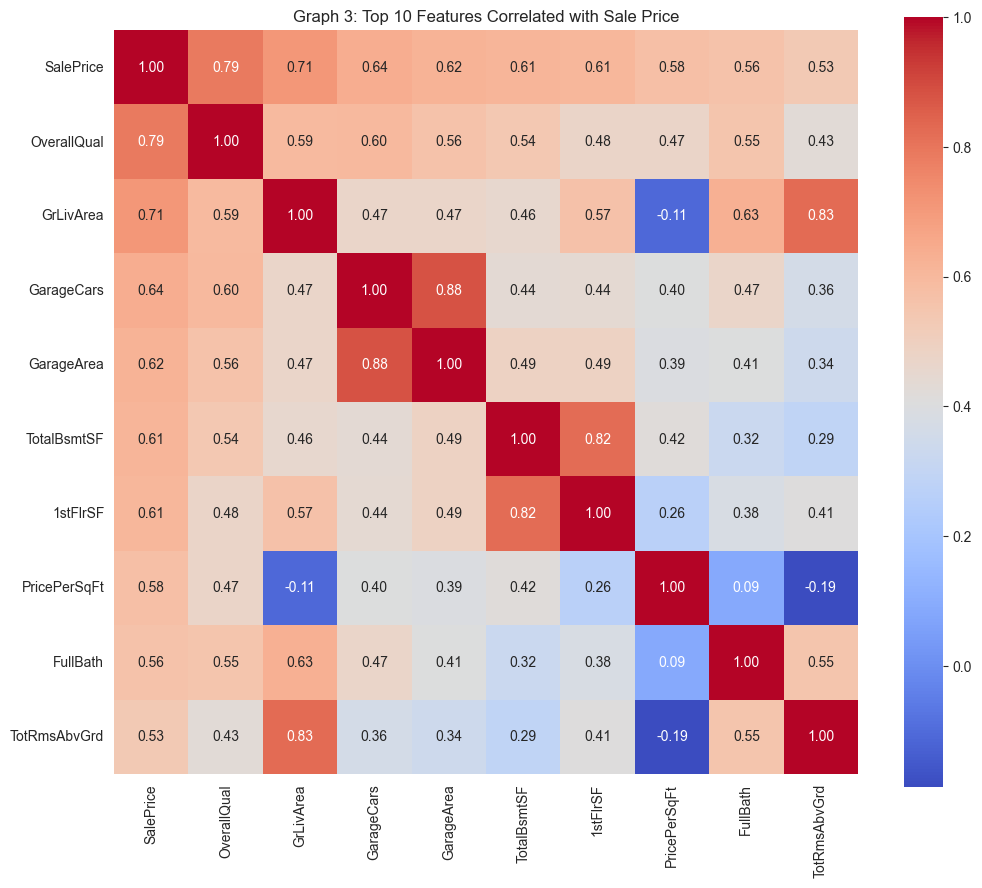

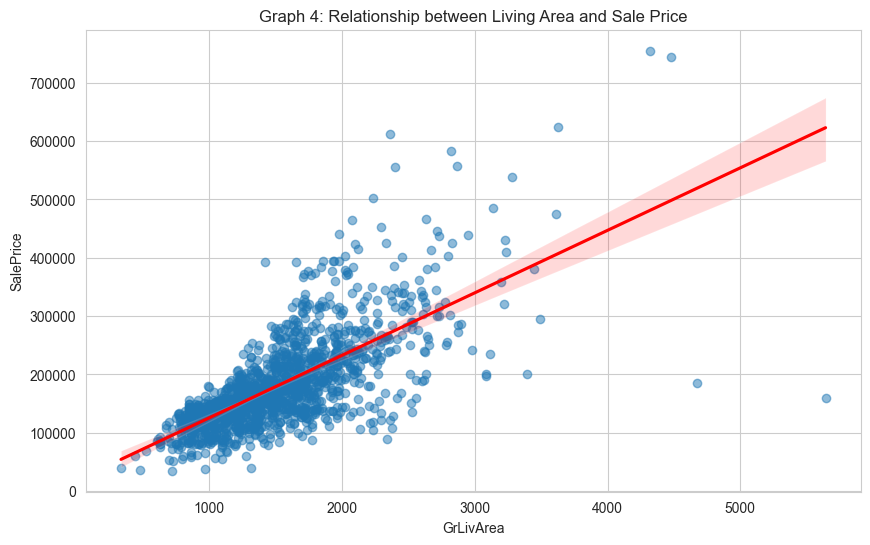

/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_47622/3229840152.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neighborhood_price.index, y=neighborhood_price.values, palette='magma')


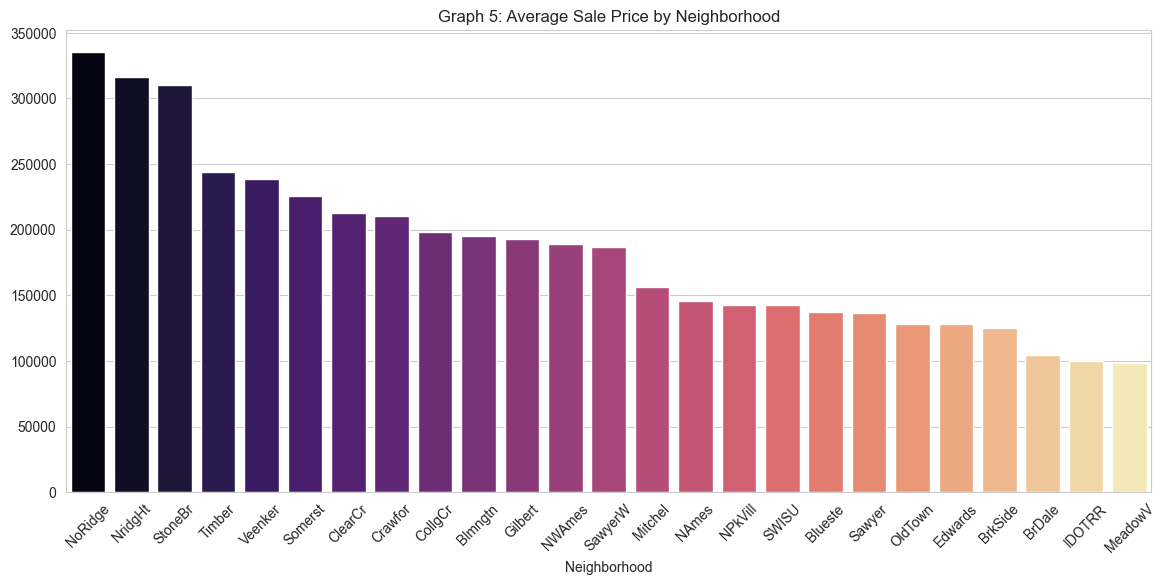

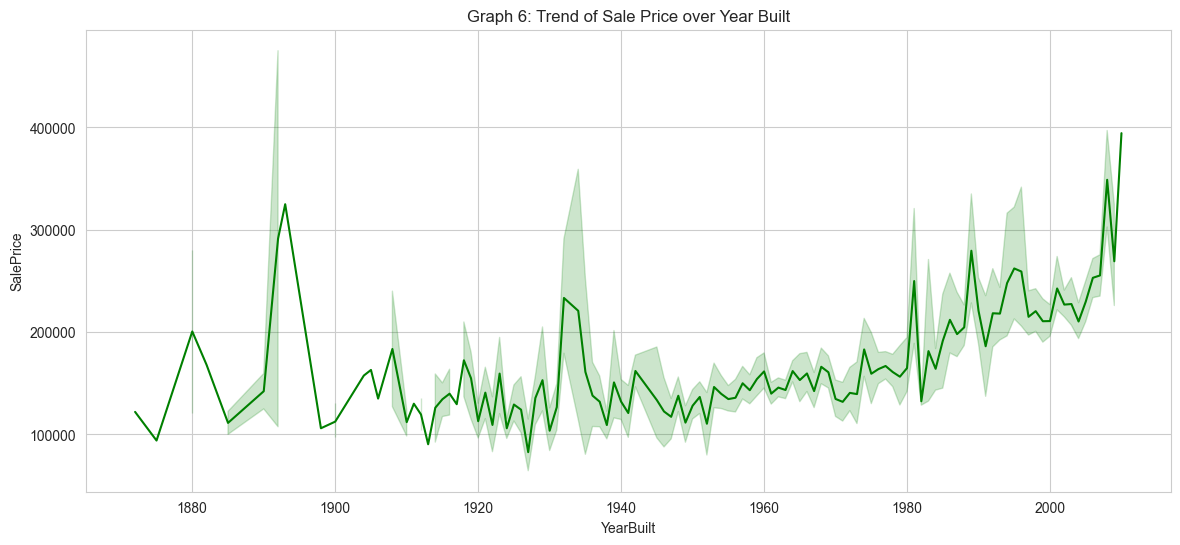

------------------------------
Model Performance Results:
Root Mean Squared Error (RMSE): $27,054.61
R-Squared (Accuracy): 86.45%
------------------------------
Feature Importance:
 OverallQual    0.589333
GrLivArea      0.181183
TotalBsmtSF    0.122110
YearBuilt      0.057520
GarageCars     0.029360
FullBath       0.020495
dtype: float64


In [ ]:
# ==========================================
# 1. IMPORT LIBRARIES & DATA
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset (input_file_0.csv is the training data with SalePrice)
df = pd.read_csv('data/train.csv')

print("Dataset Shape:", df.shape)
print("Data Types:\n", df.dtypes.head())

# ==========================================
# 2. DATA CLEANSING
# ==========================================
# 2.1 Handle Missing Values
# In this dataset, NA often means "None" (e.g. No Alley, No Garage), not missing data.
cols_fill_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                  'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                  'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for col in cols_fill_none:
    df[col] = df[col].fillna('None')

# For numerical columns like LotFrontage, fill with Median
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

# Drop rows where Electrical is missing (very few)
df = df.dropna(subset=['Electrical'])

print("\nMissing values after cleansing:", df.isnull().sum().sum())

# 2.2 Feature Engineering
# Create 'PricePerSqFt' for analysis
df['PricePerSqFt'] = df['SalePrice'] / df['GrLivArea']

# ==========================================
# 3. EXPLORATORY DATA ANALYSIS (EDA) - 6 GRAPHS
# ==========================================
sns.set_style("whitegrid")

# Graph 1: Distribution of Sale Price
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, color='blue')
plt.title('Graph 1: Distribution of Property Sale Prices')
plt.xlabel('Sale Price')
plt.show()

# Graph 2: Overall Quality vs Sale Price
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='viridis')
plt.title('Graph 2: Impact of Overall Quality on Sale Price')
plt.show()

# Graph 3: Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
correlation = numeric_df.corr()
# Select only top correlated features to SalePrice
k = 10
cols = correlation.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
            yticklabels=cols.values, xticklabels=cols.values, cmap='coolwarm')
plt.title('Graph 3: Top 10 Features Correlated with Sale Price')
plt.show()

# Graph 4: Living Area vs Sale Price (Regression Plot)
plt.figure(figsize=(10, 6))
sns.regplot(x='GrLivArea', y='SalePrice', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Graph 4: Relationship between Living Area and Sale Price')
plt.show()

# Graph 5: Average Price by Neighborhood
plt.figure(figsize=(14, 6))
neighborhood_price = df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)
sns.barplot(x=neighborhood_price.index, y=neighborhood_price.values, palette='magma')
plt.xticks(rotation=45)
plt.title('Graph 5: Average Sale Price by Neighborhood')
plt.show()

# Graph 6: Year Built vs Sale Price
plt.figure(figsize=(14, 6))
sns.lineplot(x='YearBuilt', y='SalePrice', data=df, color='green')
plt.title('Graph 6: Trend of Sale Price over Year Built')
plt.show()

# ==========================================
# 4. MACHINE LEARNING MODEL (Regression)
# ==========================================
# Select features for the model
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
X = df[features]
y = df['SalePrice']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train Model (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("-" * 30)
print("Model Performance Results:")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R-Squared (Accuracy): {r2*100:.2f}%")
print("-" * 30)

# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importance:\n", importances)

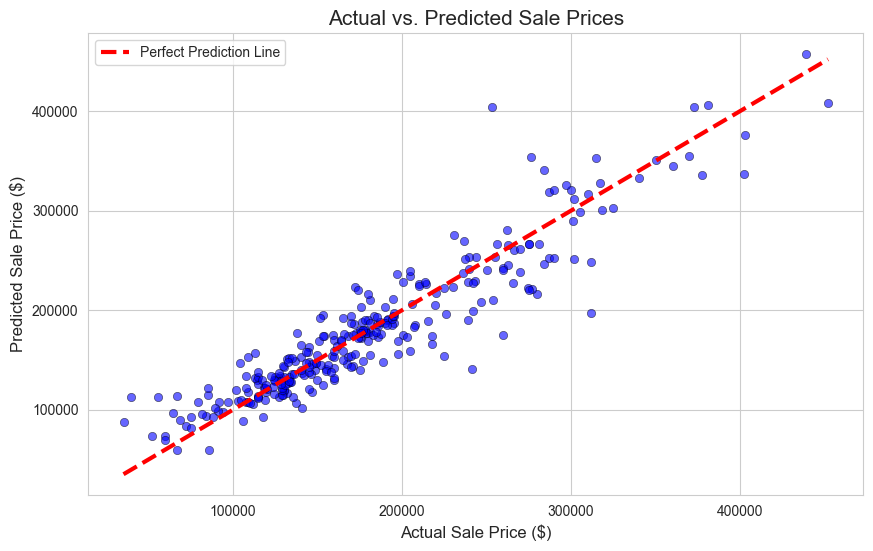

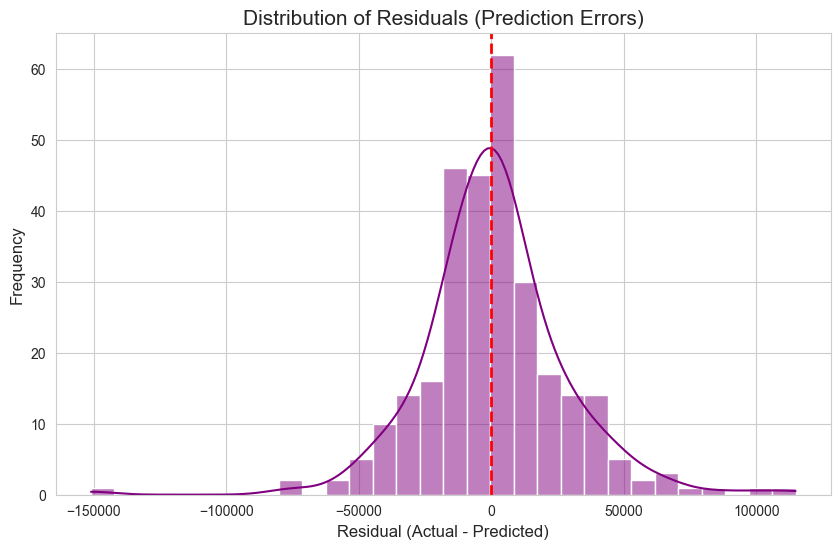

Mean Residual: $905.83


In [2]:
# ==========================================
# 5. VISUALIZING MODEL PERFORMANCE
# ==========================================

# 5.1 Scatter Plot: Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue', edgecolor='k')

# Add a red diagonal line representing perfect prediction
# If dots fall exactly on this line, the prediction is perfect.
m, b = np.polyfit(y_test, y_pred, 1) # Calculate trendline
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Perfect Prediction Line')

plt.xlabel('Actual Sale Price ($)', fontsize=12)
plt.ylabel('Predicted Sale Price ($)', fontsize=12)
plt.title('Actual vs. Predicted Sale Prices', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

# 5.2 Residual Distribution Plot
# This shows the "error" (difference between actual and predicted)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2) # Line at 0 error
plt.title('Distribution of Residuals (Prediction Errors)', fontsize=15)
plt.xlabel('Residual (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

print(f"Mean Residual: ${np.mean(residuals):,.2f}")